# 16 Regression Discontinuity Design

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

style.use("fivethirtyeight")

## Is Alcohol killing you?

- alcohol이 death에 대한 영향이 궁금하다.
- US에서는 21세 전까지는 술을 마실 수 없고 21세부터는 마실 수 있다.

In [2]:
drinking = pd.read_csv("./data/drinking.csv")
drinking.head()[["agecell", "all", "mva", "suicide"]]

# mva: moving vehicle accident
# 각 row는 평균값

,agecell,all,mva,suicide
0,19.068493,92.825400,35.829327,11.203714
1,19.150684,95.100740,35.639256,12.193368
2,19.232876,92.144295,34.205650,11.715812
3,19.315070,88.427760,32.278957,11.275010
4,19.397260,88.704940,32.650967,10.984314


In [3]:
drinking["agecell"] -= 21

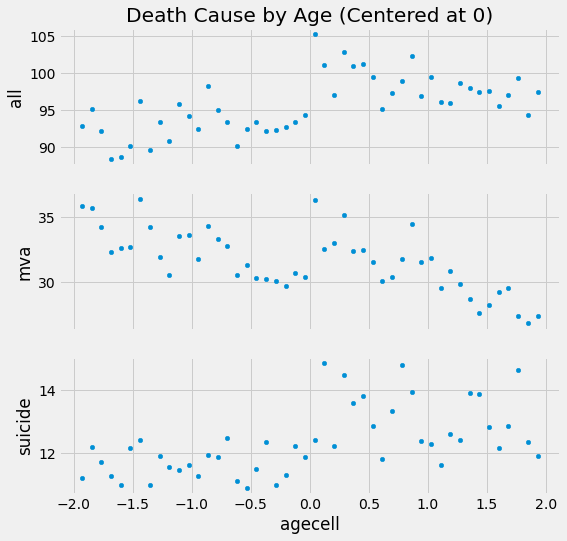

In [4]:
plt.figure(figsize=(8,8))
ax = plt.subplot(3,1,1)
drinking.plot.scatter(x="agecell", y="all", ax=ax)
plt.title("Death Cause by Age (Centered at 0)")

ax = plt.subplot(3,1,2, sharex=ax)
drinking.plot.scatter(x="agecell", y="mva", ax=ax)

ax = plt.subplot(3,1,3, sharex=ax)
drinking.plot.scatter(x="agecell", y="suicide", ax=ax);

- 그래프를 보면 21세를 기준으로 값이 jump하는 것처럼 보인다.
- discontinuity가 있다.

## RDD Estimation

- RDD의 key assumption: the smoothness of the potential outcome at the threshold
- 이 뜻은 위의 데이터에서 21세 처럼 threshold를 기준으로 왼쪽의 limits of potential outcome과 오른쪽의 limits of potential outcome가 같아야 한다는 것을 의미한다.

$$\lim_{r \to c^-} E[Y_{ti}|R_i=r] = \lim_{r \to c^+} E[Y_{ti}|R_i=r]$$

- 이 가정이 성립하면 causal effect at the threshold를 찾을 수 있다.

$$\begin{split}
\begin{align}
\lim_{r \to c^+} E[Y_{ti}|R_i=r] - \lim_{r \to c^-} E[Y_{ti}|R_i=r] =&\lim_{r \to c^+} E[Y_{1i}|R_i=r] - \lim_{r \to c^-} E[Y_{0i}|R_i=r] \\
=& E[Y_{1i}|R_i=r] - E[Y_{0i}|R_i=r] \\
=& E[Y_{1i} - Y_{0i}|R_i=r]
\end{align}
\end{split}$$
 
 - 이는 LATE이다.
   - 우리는 threshold에 해당하는 ATE만 알 수 있기 때문에
 - RDD를 local randomized trial이라고 생각할 수도 있다.
   - 특정 시점에서 어떤 사람은 21세 이하, 어떤 사람은 이상이다.
   - 이는 random이기에 local RCT라고 생각할 수 있다.

- 이제 RDD estimation을 해보자.

$$y_i = \beta_0 + \beta_1 r_i + \beta_2 \mathcal{1}\{r_i>c\} + \beta_3 \mathcal{1}\{r_i>c\} r_i$$

- 위의 linear 모델은 threshold를 기준으로 2가지 모델을 만드는 것이다.
- $r_i$ 변수에 threshold centering을 하면

$$\lim_{r \to c^+} E[Y_{ti}|R_i=r] - \lim_{r \to c^-} E[Y_{ti}|R_i=r]=\beta_2=E[ATE|R=c]$$


In [5]:
rdd_df = drinking.assign(threshold=(drinking["agecell"] > 0).astype(int))

model = smf.wls("all~agecell*threshold", rdd_df).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.6184,0.932,100.399,0.000,91.739,95.498
agecell,0.8270,0.819,1.010,0.318,-0.823,2.477
threshold,7.6627,1.319,5.811,0.000,5.005,10.320
agecell:threshold,-3.6034,1.158,-3.111,0.003,-5.937,-1.269


- 이는 100 * ((7.6627 + 93.6184) / 93.6184 - 1) = 8%의 증가를 보여준다.

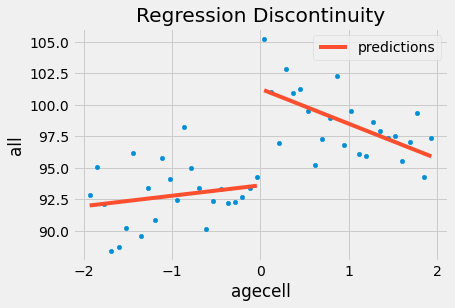

In [6]:
ax = drinking.plot.scatter(x="agecell", y="all", color="C0")
drinking.assign(predictions=model.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity");

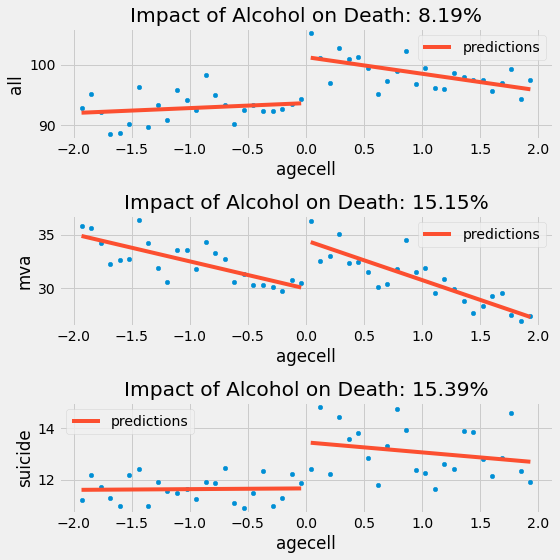

In [7]:
plt.figure(figsize=(8,8))

for p, cause in enumerate(["all", "mva", "suicide"], 1):
    ax = plt.subplot(3,1,p)
    drinking.plot.scatter(x="agecell", y=cause, ax=ax)
    m = smf.wls(f"{cause}~agecell*threshold", rdd_df).fit()
    ate_pct = 100*((m.params["threshold"] + m.params["Intercept"])/m.params["Intercept"] - 1)
    drinking.assign(predictions=m.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
    plt.title(f"Impact of Alcohol on Death: {np.round(ate_pct, 2)}%")

plt.tight_layout()

## kernal Weighting

- threshold 근처의 데이터에 더 많은 weight를 줄 수 있다.
- 이를 위해 kernel을 이용해보자.

$$K(R, c, h) = \mathcal{1}\{|R-c| \leq h\} * \bigg(1-\frac{|R-c|}{h}\bigg)$$



In [8]:
def kernel(R, c, h):
    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)

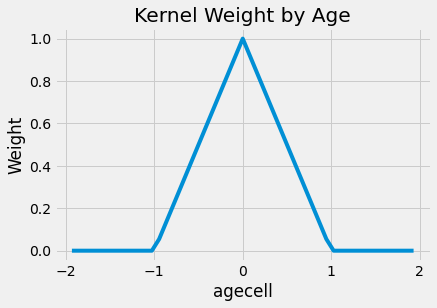

In [9]:
plt.plot(drinking["agecell"], kernel(drinking["agecell"], c=0, h=1))
plt.xlabel("agecell")
plt.ylabel("Weight")
plt.title("Kernel Weight by Age");

In [10]:
model = smf.wls("all~agecell*threshold", rdd_df,
                weights=kernel(drinking["agecell"], c=0, h=1)).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.2002,0.731,127.429,0.000,91.726,94.674
agecell,0.4109,1.789,0.230,0.819,-3.196,4.017
threshold,9.7004,1.034,9.378,0.000,7.616,11.785
agecell:threshold,-7.1759,2.531,-2.835,0.007,-12.276,-2.075


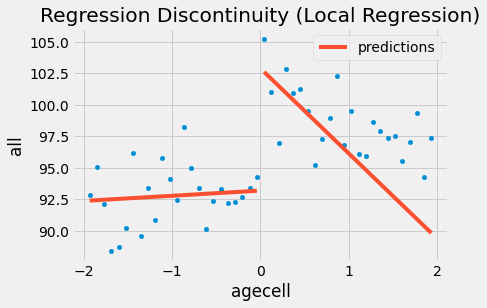

In [11]:
ax = drinking.plot.scatter(x="agecell", y="all", color="C0")
drinking.assign(predictions=model.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity (Local Regression)");

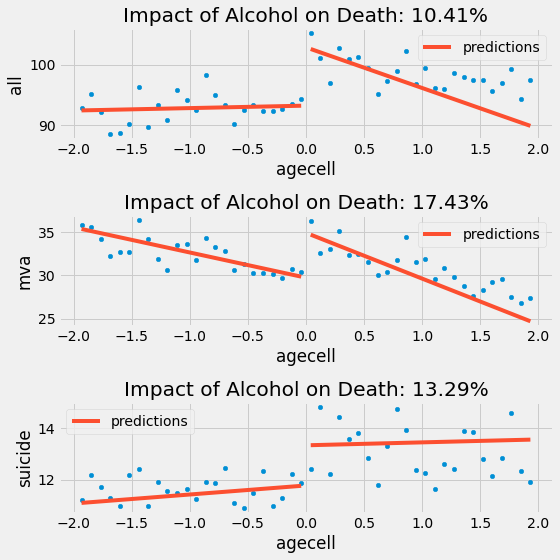

In [12]:
plt.figure(figsize=(8,8))
weights = kernel(drinking["agecell"], c=0, h=1)

for p, cause in enumerate(["all", "mva", "suicide"], 1):
    ax = plt.subplot(3,1,p)
    drinking.plot.scatter(x="agecell", y=cause, ax=ax)
    m = smf.wls(f"{cause}~agecell*threshold", rdd_df, weights=weights).fit()
    ate_pct = 100*((m.params["threshold"] + m.params["Intercept"])/m.params["Intercept"] - 1)
    drinking.assign(predictions=m.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
    plt.title(f"Impact of Alcohol on Death: {np.round(ate_pct, 2)}%")

plt.tight_layout()

## Sheepskin Effect and Fuzzzy RDD